# Multi-armed bandit
### Thompson sampling with success probability constraint and stochastic rewards

In [1]:
from matplotlib import pyplot as plt
from cvxopt import matrix, solvers

import numpy as np
import ray
import time

plt.rcParams.update({'font.size': 22, 'lines.linewidth' : 3})

ray.init(redis_address="172.18.0.8:15672", ignore_reinit_error=True)

{'node_ip_address': '172.18.0.8',
 'redis_address': '172.18.0.8:15672',
 'object_store_address': '/tmp/ray/session_2020-02-07_15-44-06_25607/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-07_15-44-06_25607/sockets/raylet',
 'webui_url': None}

In [2]:
@ray.remote
def f():
    time.sleep(0.01)
    return ray.services.get_node_ip_address()

# Get a list of the IP addresses of the nodes that have joined the cluster.
ray_node_ips = set(ray.get([f.remote() for _ in range(1000)]))
print('Number of active Ray nodes: %d'%(len(ray_node_ips)))

Number of active Ray nodes: 1


# Load Offline Model

16


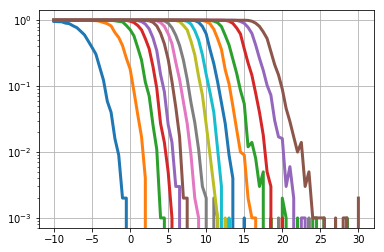

In [3]:
awgn_datafile = 'AWGN_CUSTOM_CONFIG_DATAFILE.npy'
awgn_data = np.load( awgn_datafile, encoding='latin1', allow_pickle=True )[ ( ) ]

snr_vs_bler = np.array(awgn_data['snr_vs_bler'])
snr_range_dB = np.array(awgn_data['snr_range_dB'])

ignore_mcs = [0, 9, 15, 19, 20, 21]

snr_vs_bler = np.delete(snr_vs_bler, ignore_mcs, 1)

nrof_snr, nrof_mcs = snr_vs_bler.shape

print(nrof_mcs)

plt.figure()
plt.grid(True)
for i in range(nrof_mcs):
    plt.semilogy(snr_range_dB, snr_vs_bler[:, i])
    
plt.show()

# CQI-related functions

In [4]:
''' Find the SINR for the given CQI to approximately achieve the given BLER target
'''
def estimate_sinr_from_cqi(cqi):

    REF_BLER_TARGET = 0.1

    awgn_snr_range_dB = awgn_data['snr_range_dB']
    awgn_snr_vs_bler = awgn_data['snr_vs_bler']

    _, nrof_cqi = awgn_snr_vs_bler.shape

    bler = awgn_snr_vs_bler[:, cqi]

    if cqi == 0:
        return np.min(awgn_snr_range_dB)
    elif cqi == nrof_cqi - 1:
        return np.max(awgn_snr_range_dB)

    index1 = np.max(np.argwhere(REF_BLER_TARGET < bler))
    index2 = np.min(np.argwhere(REF_BLER_TARGET > bler))

    estimated_sinr_dB = (awgn_snr_range_dB[index1] + awgn_snr_range_dB[index2]) / 2.0

    return estimated_sinr_dB

def determine_mcs_from_sinr(sinr_dB, target_success_prob, mean_reward):
    awgn_snr_range_dB = awgn_data['snr_range_dB']
    awgn_snr_vs_bler = awgn_data['snr_vs_bler']

    _, nrof_cqi = awgn_snr_vs_bler.shape
    bler_target = 1.0 - target_success_prob

    bler_at_snr = determine_bler_at_sinr(sinr_dB)

    # Find the largest MCS that has BLER less than the BLER target
    # The CQIs are evaluated in decreasing order and first value that predicts a BLER < 0.1
    # is returned.
    largest_mcs = 0
    for i in range(nrof_cqi):
        current_mcs = nrof_cqi - i - 1
        if bler_at_snr[current_mcs] < bler_target:
            largest_mcs = current_mcs
            break
        else:
            continue

    # Determine the expected tput for all valid MCSs
    best_mcs = 0
    best_expected_tput = 0
    for i in range( largest_mcs ):
        expected_tput = ( 1 - bler_at_snr[ i ] ) * float( mean_reward[ i ] )
        if expected_tput > best_expected_tput:
            best_expected_tput = expected_tput
            best_mcs = i

    return best_mcs

def determine_bler_at_sinr(sinr_dB):
    awgn_snr_range_dB = awgn_data['snr_range_dB']
    awgn_snr_vs_bler = awgn_data['snr_vs_bler']

    _, nrof_cqi = awgn_snr_vs_bler.shape

    bler_at_sinr = np.ndarray((nrof_cqi, 1))

    for i in range(nrof_cqi):
        bler = awgn_snr_vs_bler[:, i]
        if sinr_dB <= np.min(awgn_snr_range_dB):
            bler_at_sinr[i] = 1.0
        elif sinr_dB >= np.max(awgn_snr_range_dB):
            bler_at_sinr[i] = 0.0
        else:
            index1 = np.max(np.argwhere(awgn_snr_range_dB < sinr_dB))
            index2 = np.min(np.argwhere(awgn_snr_range_dB > sinr_dB))

            bler_at_sinr[i] = (bler[index1] + bler[index2]) / 2.0

    return bler_at_sinr

In [5]:
snr_index = 32
snr_level = snr_range_dB[snr_index]
print('SNR level: %0.2f dB'%(snr_level))

nrof_arms = nrof_mcs
success_prob = 1.0 - snr_vs_bler[snr_index, :]

reward_value = [ 20, 20, 40, 64, 84, 104, 124, 148, 168, 148, 188, 232, 272, 316, 356, 400, 408, 472, 536, 900, 660, 724 ]
reward_value = [r for i, r in enumerate(reward_value) if i not in ignore_mcs]

target_success_prob = 0.85

SNR level: 6.00 dB


In [6]:
print(success_prob)

cqi = max(np.argwhere(success_prob >= 0.9))[0]
print('CQI: %d'%(cqi))

[1.    1.    1.    1.    0.997 0.952 0.77  0.409 0.012 0.    0.    0.
 0.    0.    0.    0.   ]
CQI: 5


In [7]:
class Environment():
    def __init__(self, success_prob, nonstationary=False, interval=1):
        self.success_prob = success_prob
        
        self.nonstationary = nonstationary
        self.interval = interval
         
    def pull(self, arm, t):
        if not self.nonstationary:
            if np.random.rand() < self.success_prob[arm]:
                return 1 # Success event
            else:
                return 0 # No reward event
            
        else:
            success_prob = self.calculate_success_prob(t)
            
            if np.random.rand() < success_prob[arm]:
                return 1 # Success event
            else:
                return 0 # No reward event
            
    # Return the success probability for Oracle and for debugging purposes
    def get_success_prob(self, t):
        if not self.nonstationary:
            return self.success_prob
        else:
            return self.calculate_success_prob(t)
    
    # Cycle linearly between the provided success probability vectors
    # Success probability vectors are provided as array of arrays
    def calculate_success_prob(self, t):
        nrof_prob_vectors = len(self.success_prob)
        nrof_arms = len(self.success_prob[0])
        
        interval_start = int(t / self.interval) * self.interval
        
        first_prob_index = int(t / self.interval) % nrof_prob_vectors
        second_prob_index = (int(t / self.interval) + 1) % nrof_prob_vectors
        
        success_prob = []
        for arm in range(nrof_arms):
            a = self.success_prob[first_prob_index][arm]
            b = self.success_prob[second_prob_index][arm]
            
            # Interpolate linearly between a and b
            prob = (a + (t - interval_start) * (b - a) / self.interval)
            
            success_prob.append(prob)
            
        return success_prob

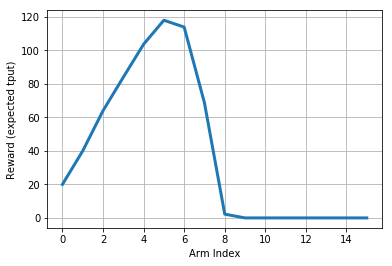

In [8]:
expected_reward = [suc_prob * rew for suc_prob, rew in zip(success_prob, reward_value)]

plt.figure()
plt.grid(True)
plt.plot(expected_reward)

plt.xlabel('Arm Index')
plt.ylabel('Reward (expected tput)')
plt.show()

# Base Constrained Bandit

In [9]:
# nrof_arms: Number of bandit arms (K)
# reward_value: Reward value for each arm (r_k) if successful
# target_success_prob: Target success probability
# window_size: Window size for sliding window bandit. Events outside the window are discarded
class BaseConstrainedBandit():
    def __init__(self, 
                 nrof_arms, 
                 reward_value, 
                 target_success_prob=0.0,
                 window_size=np.Inf):
        
        self.nrof_arms = nrof_arms
        self.reward_value = reward_value
        
        self.target_success_prob = target_success_prob
        self.window_size = window_size
        
        self.t = 0
        
        self.pull_count = [0 for _ in range(self.nrof_arms)]
        self.success_count = [0 for _ in range(self.nrof_arms)]
        
        self.pulled_arm = []
        self.observed_success = []
       
    # Determine which arm to be pulled
    def act(self): # Implemented in child classes
        pass
    
    # Update the bandit
    def update(self, arm, success):  
        self.t += 1
                
        self.pull_count[arm] += 1       
        self.success_count[arm] += success
        
        if not self.window_size == np.Inf:
            self.pulled_arm.append(arm)
            self.observed_success.append(success)
            
            if self.t > self.window_size:
                obsolete_arm = self.pulled_arm[self.t - self.window_size - 1]
                obsolete_success = self.observed_success[self.t - self.window_size - 1]
                
                if self.pull_count[obsolete_arm] > 1:
                    self.pull_count[obsolete_arm] -= 1
                    self.success_count[obsolete_arm] -= obsolete_success
         
    # Calculate the selection probability vector by solving a linear program
    def calculate_selection_probabilities(self, success_prob, tolerance=1e-5):
        c = matrix(-1 * np.array(success_prob) * np.array(self.reward_value))

        neg_success_prob = [-1.0 * r for r in success_prob]
        
        G = matrix(np.vstack([neg_success_prob, -1.0 * np.eye(self.nrof_arms)]))
        h = matrix(np.append(-1 * self.target_success_prob, np.zeros((1, self.nrof_arms))))

        A = matrix(np.ones((1, self.nrof_arms)))
        b = matrix([1.0])

        sol = solvers.lp(c, G, h, A, b)
        
        selection_prob = np.reshape(np.array(sol['x']), -1)
        
        if None in selection_prob: # Unsolvable optimiation
            return [None]
            
        # Fix numerical issues
        selection_prob[np.abs(selection_prob) < tolerance] = 0.0  # Remove precision-related values
        selection_prob = selection_prob / sum(selection_prob)     # Recalibrate probability vector to sum to 1
        
        return selection_prob
    
    # Sample from the probabilistic selection vector
    def sample_prob_selection_vector(self, prob):
        try:
            return np.argwhere(np.random.multinomial(1, prob))[0][0]
            # return dependent_rounding(prob)
        except: # Throws ValueError somtimes
            print('Error thrown by prob sampling. Returning random sample')
            return np.random.randint(0, self.nrof_arms)

# Oracle Constrained Bandit

In [10]:
# nrof_arms: Number of bandit arms (K)
# reward_value: Reward value for each arm (r_k) if successful
# target_success_prob: Target success probability
# success_prob: Success probability for each bandit arm
class OracleConstrainedBandit(BaseConstrainedBandit):
    def __init__(self, 
                 nrof_arms, 
                 reward_value, 
                 target_success_prob=0.0,
                 env_instance=None):
        
        super().__init__(nrof_arms, reward_value, target_success_prob)
        self.env = env_instance
    
    # Determine which arm to be pulled
    def act(self):
        success_prob = self.env.get_success_prob(self.t)
        selection_prob = self.calculate_selection_probabilities(success_prob)
        
       # print(success_prob)
        
        return self.sample_prob_selection_vector(selection_prob)
    
    # Get selection probabilties (for debugging purposes)
    def get_selection_prob(self):
        return self.prob

# Thompson Sampling Bandit
## Provides:
## (i) Unimodal Thompson sampling (UTS)
## (ii) Constrained Thompson sampling (Con-TS)

In [11]:
class ThompsonSamplingBandit(BaseConstrainedBandit):
    def __init__(self, 
                 nrof_arms, 
                 reward_value, 
                 target_success_prob=0.0,
                 window_size=np.Inf,
                 unimodal=False,
                 prior_success_mean=[]):
        
        super().__init__(nrof_arms, reward_value, target_success_prob, window_size)
        
        # Exploit Unimodality
        self.unimodal = unimodal
        self.leader_count = [0 for _ in range(nrof_arms)]
        self.gamma = 2
        
        # Exploit prior knowledge
        if not prior_success_mean == []:
            self.informed_prior = True
            
            prior_weight = 10
            for arm in range(self.nrof_arms):
                self.success_count[arm] = 1 + int(prior_weight * prior_success_mean[arm])
                
                fail_count = 1 + int(prior_weight * (1.0 - prior_success_mean[arm]))
                self.pull_count[arm] = self.success_count[arm] + fail_count
        else:
            self.informed_prior = False
                
    # Determine which arm to be pulled
    def act(self):
        # Ensure that each arm is pulled at least once
        if not self.informed_prior:
            if self.t < self.nrof_arms:
                return self.t
        
        # Sample a success probability from beta distribution Beta(a, b)
        # where a = 1 + self.success_count[arm]
        # and   b = 1 + self.pull_count[arm] - self.success_count[arm]
        sampled_success_prob = [ np.random.beta(1 + self.success_count[arm], 
                                                1 + self.pull_count[arm] - self.success_count[arm]) 
                                for arm in range(self.nrof_arms)]
        
        #if self.t % 1000 == 0:
        #    print(sampled_reward_event_prob)
        #    print([x + y for x, y in zip(self.reward_event_count, self.no_reward_event_count)])
        
        if self.unimodal:
            sampled_expected_rewards = [(suc * rew) for suc, rew in zip(sampled_success_prob, self.reward_value)]
            return self.best_arm_unimodal(sampled_expected_rewards)
        
        # Success probability constraint through linear programming
        ts_prob = self.calculate_selection_probabilities(sampled_success_prob)
        if None in ts_prob: # Unsolvable optimization
            #if self.t % 1000 == 0:
            #    print('No solution found!')
                
            #return np.random.randint(0, self.nrof_arms)
            sampled_expected_rewards = [(suc * rew) for suc, rew in zip(sampled_success_prob, self.reward_value)]
            return np.argmax(sampled_expected_rewards)
        else:
            return self.sample_prob_selection_vector(ts_prob)   
        
    # Estimate the best arm as per the Unimodal Thompson Sampling algorithm
    def best_arm_unimodal(self, sampled_success_prob):
        emprical_mean = [(self.success_count[i] / self.pull_count[i]) for i in range(self.nrof_arms)]
        expected_mean_reward = [(mean * rew) for mean, rew in zip(emprical_mean, self.reward_value)]
        
        leader_arm = np.argmax(expected_mean_reward)
        l_n = self.leader_count[leader_arm]
             
        if (l_n - 1) % (self.gamma + 1) == 0:
            best_arm = leader_arm
        else:
            expected_sampled_reward = [(suc_prob * rew) for suc_prob, rew in zip(sampled_success_prob, 
                                                                                 self.reward_value)]
            
            if leader_arm < 2:
                if expected_sampled_reward[0] > expected_sampled_reward[1]:
                    best_arm = 0
                else:
                    best_arm = 1
            elif leader_arm < self.nrof_arms - 1:
                neighborhood_reward = expected_sampled_reward[leader_arm - 1 : leader_arm + 2]
                best_arm = (leader_arm - 1) + np.argmax(neighborhood_reward)
            else:
                if expected_sampled_reward[self.nrof_arms - 2] > expected_sampled_reward[self.nrof_arms - 1]:
                    best_arm = self.nrof_arms - 2
                else:
                    best_arm = self.nrof_arms - 1

        self.leader_count[best_arm] += 1

        return best_arm

# Outer Loop Link Adaptation
## Bandit-like interface for OLLA

In [12]:
class OuterLoopLinkAdaptation(BaseConstrainedBandit):
    def __init__(self, 
                 nrof_arms, 
                 reward_value, 
                 target_success_prob=0.0,
                 window_size=np.Inf,
                 cqi=-1):
        
        super().__init__(nrof_arms, reward_value, target_success_prob, window_size)
        
        self.cqi = cqi

        self.sinr_offset = 0.0
        self.olla_step_size = 0.1
        
        self.sinr_step_history = []

    def update(self, arm, success):
        if success:
            sinr_step = self.olla_step_size
            self.sinr_offset +=  self.olla_step_size
        else:
            sinr_step = -1 * self.target_success_prob / (1.0 - self.target_success_prob) * self.olla_step_size 
        
        self.sinr_offset +=  sinr_step
        
        self.sinr_step_history.append(sinr_step)
        
        super().update(arm, success)
        if self.t > self.window_size:
            self.sinr_offset -= self.sinr_step_history[self.t - self.window_size - 1]
        

    def act(self):
        arm = []

        if self.cqi == 0:
            arm = 0
        else:
            estimated_sinr = estimate_sinr_from_cqi(self.cqi)
            adjusted_sinr = estimated_sinr + self.sinr_offset

            arm = determine_mcs_from_sinr(adjusted_sinr, self.target_success_prob, self.reward_value)

        return arm

In [13]:
@ray.remote # Comment out this line to run locally
def run_experiment(policy, T, play_result, reward_value):
    outcome = np.zeros((T, 2))
    for t in range(T):    
        arm = policy.act()
        success = play_result[t][arm]

        outcome[t, 0] = success
        
        if success:
            outcome[t, 1] = reward_value[arm]
        
        policy.update(arm, success)
        
    return outcome

In [14]:
def play(policy, T, N, play_result, reward_value, name):
    start = time.time()
    
    # Uncomment the following line to run locally
    #outcome = [run_experiment(policy, T, play_result[n], reward_value) for n in range(N)]
    outcome = ray.get([run_experiment.remote(policy, T, play_result[n], reward_value) for n in range(N)])
        
    total_success = np.zeros((T))
    total_reward = np.zeros((T))
    for n in range(N):
        total_success += outcome[n][:, 0]
        total_reward += outcome[n][:, 1]
    
    print(name + ' done! Elasped: %0.2fs'%(time.time() - start))
    
    return (total_success / N, total_reward / N)

In [ ]:
T = 1000
N = 100

# Generate all events in advance
np.random.seed(42)
env = Environment(success_prob)

play_result = [[[env.pull(arm, t) for arm in range(nrof_arms)] for t in range(T)] for _ in range(N)]

solvers.options['show_progress'] = False

oracle_avg_success, oracle_avg_reward = play( OracleConstrainedBandit(nrof_arms,
                                                                      reward_value,  
                                                                      target_success_prob,
                                                                      env_instance=env), 
                                              T, 
                                              N, 
                                              play_result, 
                                              reward_value, 
                                              'Oracle' )

con_ts_avg_success, con_ts_avg_reward = play( ThompsonSamplingBandit(nrof_arms,
                                                                     reward_value,
                                                                     target_success_prob), 
                                        T, 
                                        N, 
                                        play_result, 
                                        reward_value,
                                        'Con-TS' )

# Informed Priors
cqi = max(np.argwhere(success_prob >= 0.9))[0]
estimated_sinr = estimate_sinr_from_cqi(cqi)
bler = determine_bler_at_sinr(estimated_sinr)
prior = [(1.0 - b) for b in bler]
    
con_ts_infp_avg_success, con_ts_infp_avg_reward = play( ThompsonSamplingBandit(nrof_arms,
                                                                               reward_value,
                                                                               target_success_prob,
                                                                               prior_success_mean=prior), 
                                              T, 
                                              N, 
                                              play_result, 
                                              reward_value,
                                              'Con-TS-Infp' )

# Outer Loop Link Adaptation
olla_avg_success, olla_avg_reward = play( OuterLoopLinkAdaptation( nrof_arms, 
                                                                   reward_value,
                                                                   target_success_prob,
                                                                   cqi=cqi), 
                                                      T, 
                                                      N, 
                                                      play_result, 
                                                      reward_value,
                                                      'OLLA' )


In [ ]:
data = {'oracle_avg_success': oracle_avg_success,
        'oracle_avg_reward': oracle_avg_reward,
        'con_ts_avg_success': con_ts_avg_success,
        'con_ts_avg_reward': con_ts_avg_reward,
        'con_ts_infp_avg_success': con_ts_infp_avg_success,
        'con_ts_infp_avg_reward': con_ts_infp_avg_reward,
        'olla_avg_success': olla_avg_success,
        'olla_avg_reward': olla_avg_reward,
        'target_success_prob': target_success_prob,
 #       'success_prob': success_prob,
        'T': T,
        'N': N}

filename = 'RESULTS/RESULTS_OLLA_%ddB.npy'%(int(snr_level))
np.save(filename, data)

# Non-stationary Environment

In [16]:
T = 1000
N = 100

success_prob_1 = 1.0 - snr_vs_bler[32, :]  # 6 dB
success_prob_2 = 1.0 - snr_vs_bler[38, :]  # 9 dB
success_prob_3 = 1.0 - snr_vs_bler[44, :]  # 12 dB

# Generate all events in advance
np.random.seed(42)
env = Environment([success_prob_1, success_prob_2, success_prob_3], True, 250)

play_result = [[[env.pull(arm, t) for arm in range(nrof_arms)] for t in range(T)] for _ in range(N)]

solvers.options['show_progress'] = False

oracle_avg_success, oracle_avg_reward = play( OracleConstrainedBandit(nrof_arms,
                                                                      reward_value,  
                                                                      target_success_prob,
                                                                      env_instance=env), 
                                              T, 
                                              N, 
                                              play_result, 
                                              reward_value, 
                                              'Oracle' )

con_ts_avg_success, con_ts_avg_reward = play( ThompsonSamplingBandit(nrof_arms,
                                                                     reward_value,
                                                                     target_success_prob,
                                                                     window_size=100), 
                                        T, 
                                        N, 
                                        play_result, 
                                        reward_value,
                                        'Con-TS' )

# Informed Priors
cqi = max(np.argwhere(success_prob >= 0.9))[0]
estimated_sinr = estimate_sinr_from_cqi(cqi)
bler = determine_bler_at_sinr(estimated_sinr)
prior = [(1.0 - b) for b in bler]
    
con_ts_infp_avg_success, con_ts_infp_avg_reward = play( ThompsonSamplingBandit(nrof_arms,
                                                                               reward_value,
                                                                               target_success_prob,
                                                                               window_size=100,
                                                                               prior_success_mean=prior), 
                                                      T, 
                                                      N, 
                                                      play_result, 
                                                      reward_value,
                                                      'Con-TS-Infp' )

# Outer Loop Link Adaptation
olla_avg_success, olla_avg_reward = play( OuterLoopLinkAdaptation( nrof_arms, 
                                                                   reward_value,
                                                                   target_success_prob,
                                                                   window_size=100,
                                                                   cqi=cqi), 
                                                                  T, 
                                                                  N, 
                                                                  play_result, 
                                                                  reward_value,
                                                                  'OLLA' )



Oracle done! Elasped: 368.83s
Con-TS done! Elasped: 354.47s
Con-TS-Infp done! Elasped: 352.17s
OLLA done! Elasped: 331.47s


In [17]:
data = {'oracle_avg_success': oracle_avg_success,
        'oracle_avg_reward': oracle_avg_reward,
        'con_ts_avg_success': con_ts_avg_success,
        'con_ts_avg_reward': con_ts_avg_reward,
        'con_ts_infp_avg_success': con_ts_infp_avg_success,
        'con_ts_infp_avg_reward': con_ts_infp_avg_reward,
        'olla_avg_success': olla_avg_success,
        'olla_avg_reward': olla_avg_reward,
        'target_success_prob': target_success_prob,
 #       'success_prob': success_prob,
        'T': T,
        'N': N}

filename = 'RESULTS/RESULTS_OLLA_NONSTATIONARY.npy'
np.save(filename, data)

# Load and plot stuff

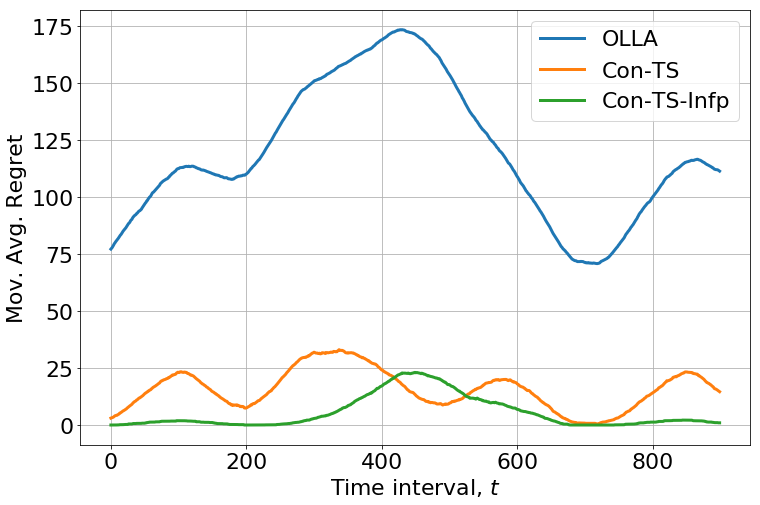

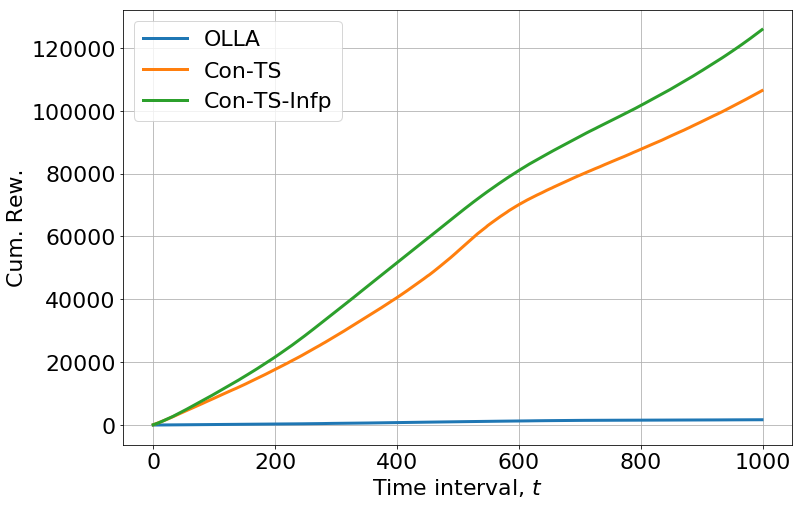

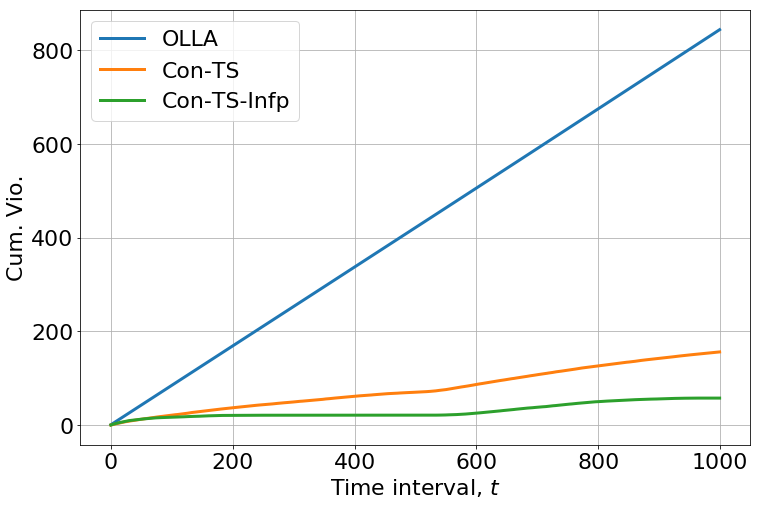

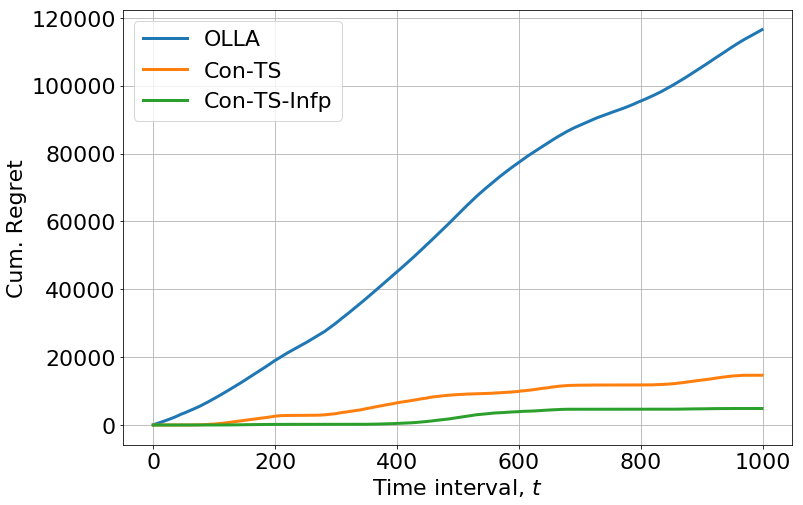

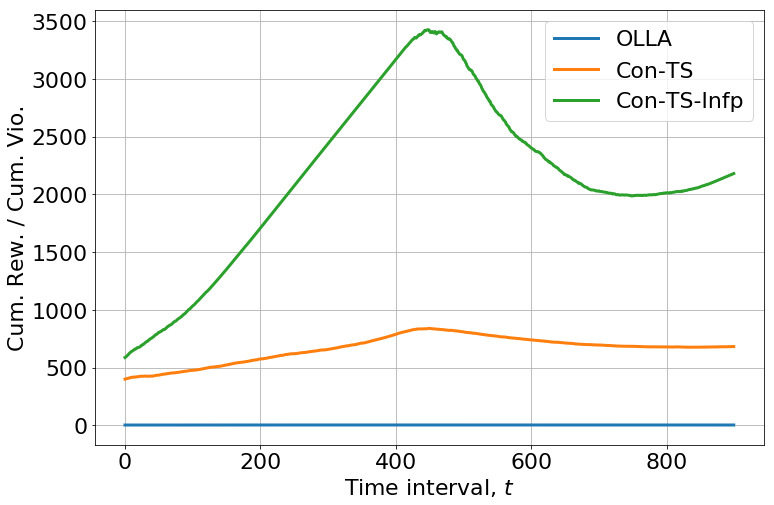

In [18]:
plt.rcParams.update({'font.size': 22, 'lines.linewidth' : 3})

olla_cum_reward = np.cumsum(data['olla_avg_reward'])
con_ts_cum_reward= np.cumsum(data['con_ts_avg_reward'])
con_ts_infp_cum_reward = np.cumsum(data['con_ts_infp_avg_reward'])
oracle_cum_reward = np.cumsum(data['oracle_avg_reward'])

def movavg(cumsum, win_size=100):
    return (cumsum[win_size:] - cumsum[:-1 * win_size]) / win_size
                             
olla_cum_vio = np.cumsum(np.maximum(0.0, target_success_prob - data['olla_avg_success']))
con_ts_cum_vio = np.cumsum(np.maximum(0.0, target_success_prob - data['con_ts_avg_success']))
con_ts_infp_cum_vio = np.cumsum(np.maximum(0.0, target_success_prob - data['con_ts_infp_avg_success']))

olla_cum_regret = np.cumsum(np.maximum(0.0, data['oracle_avg_reward'] - data['olla_avg_reward']))
con_ts_cum_regret= np.cumsum(np.maximum(0.0, data['oracle_avg_reward'] - data['con_ts_avg_reward']))
con_ts_infp_cum_regret = np.cumsum(np.maximum(0.0, data['oracle_avg_reward'] - data['con_ts_infp_avg_reward']))

# Mov. Avg. Regret
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(movavg(olla_cum_regret))
plt.plot(movavg(con_ts_cum_regret))
plt.plot(movavg(con_ts_infp_cum_regret))

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Mov. Avg. Regret')

plt.show()

# Cum. Rew.
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(olla_cum_reward)
plt.plot(con_ts_cum_reward)
plt.plot(con_ts_infp_cum_reward)

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Rew.')

plt.show()

# Cum. Vio.
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(olla_cum_vio)
plt.plot(con_ts_cum_vio)
plt.plot(con_ts_infp_cum_vio)

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Vio.')

plt.show()

# Cum. Regret
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(olla_cum_regret)
plt.plot(con_ts_cum_regret)
plt.plot(con_ts_infp_cum_regret)

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Regret')

plt.show()

# Cum. Rew. / Cum. Vio.
plt.figure(figsize=[12, 8])
plt.grid(True)

offset = 100
plt.plot(np.divide(olla_cum_reward[offset:], olla_cum_vio[offset:]))
plt.plot(np.divide(con_ts_cum_reward[offset:], con_ts_cum_vio[offset:]))
plt.plot(np.divide(con_ts_infp_cum_reward[offset:], con_ts_infp_cum_vio[offset:]))

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Rew. / Cum. Vio.')

plt.show()

Text(0, 0.5, 'Average Reward Events  $E[x_{k(t)}]$')

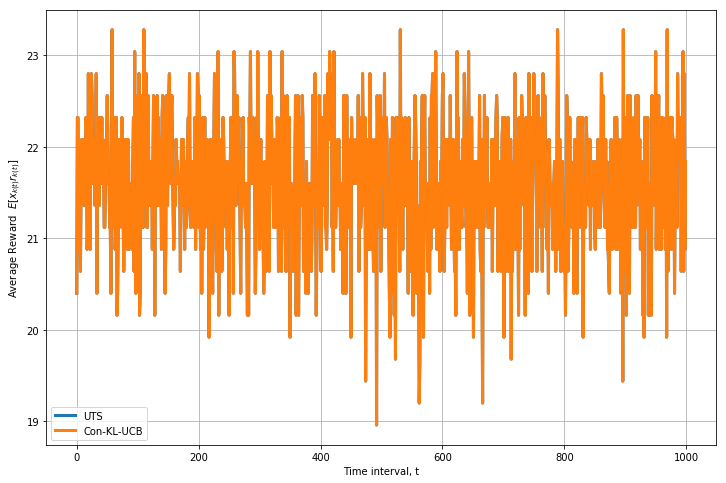

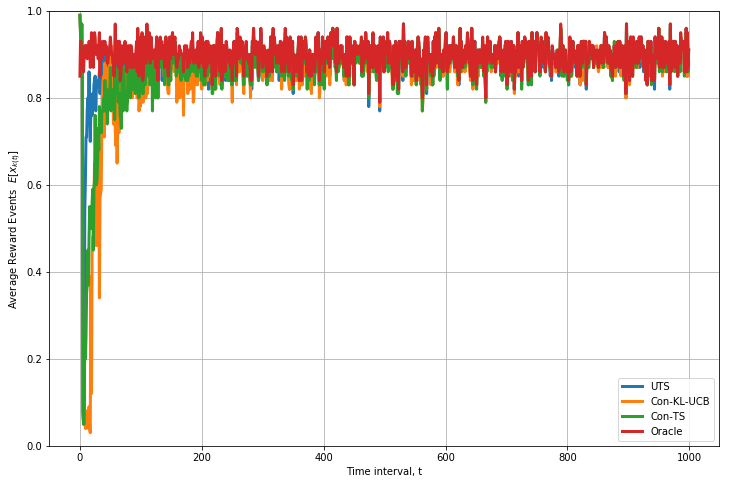

In [51]:
plt.figure(figsize=[12, 8])
plt.grid(True)

#plt.plot(data['uts_avg_reward'])
#plt.plot(data['con_kl_ucb_avg_reward'])
#plt.plot(data['con_ts_avg_reward'])
plt.plot(oracle1_avg_reward)
plt.plot(data['oracle_avg_reward'])

plt.legend(['UTS', 'Con-KL-UCB', 'Con-TS', 'Oracle'])

#plt.ylim([0.0, 1])
plt.xlabel('Time interval, t')
plt.ylabel('Average Reward  $E[x_{k(t)}r_{k(t)}]$')


plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(data['uts_avg_success'])
plt.plot(data['con_kl_ucb_avg_success'])
plt.plot(data['con_ts_avg_success'])
plt.plot(data['oracle_avg_success'])

plt.legend(['UTS', 'Con-KL-UCB', 'Con-TS', 'Oracle'])

plt.ylim([0, 1])
plt.xlabel('Time interval, t')
plt.ylabel('Average Reward Events  $E[x_{k(t)}]$')